#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    Вычисляет значение функции потерь Elastic Net для логистической регрессии.

    Args:
        X: Матрица признаков, shape = (N, K)
        y: Вектор меток (предполагается y ∈ {-1, 1}), shape = (N,)
        w: Веса модели, List[float] длины K
        w0: Смещение модели, scalar
        gamma: Коэффициент L1-регуляризации (по умолчанию 1.0)
        beta: Коэффициент L2-регуляризации (по умолчанию 1.0)

    Returns:
        Значение функции потерь (scalar)
    """

    # Преобразование весов в numpy массив
    w_np = np.array(w)
    # Количество объектов
    N = len(y)

    # Линейный вывод модели для всех объектов
    linear_output = X @ w_np + w0
    # Вычисляем логистическую потерю для каждого объекта
    exp_neg_prod = np.exp(-y * linear_output)
    logistic_loss_per_sample = np.log(1 + exp_neg_prod)
    # Средняя логистическая потеря по всем объектам
    mean_logistic_loss = np.mean(logistic_loss_per_sample)

    # Вычисляем L1-норму весов
    l1_norm = np.sum(np.abs(w_np))
    # Вычисляем квадрат L2-нормы весов
    l2_norm_squared = np.sum(w_np ** 2)
    # Полная потеря = средняя логистическая потеря + gamma * L1 + beta * L2
    total_loss = mean_logistic_loss + gamma * l1_norm + beta * l2_norm_squared

    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    """
    Вычисляет градиент функции потерь Elastic Net для логистической регрессии.

    Args:
        X: Матрица признаков, shape = (N, K)
        y: Вектор меток (предполагается y ∈ {-1, 1}), shape = (N,)
        w: Веса модели, List[float] длины K
        w0: Смещение модели, scalar
        gamma: Коэффициент L1-регуляризации (по умолчанию 1.0)
        beta: Коэффициент L2-регуляризации (по умолчанию 1.0)

    Returns:
        Кортеж (grad_w, grad_w0), где grad_w - список градиентов по весам,
        grad_w0 - градиент по смещению.
    """

    # Преобразование весов в numpy-массив
    w_np = np.array(w)
    # Количество объектов
    N = X.shape[0]

    # Линейный вывод модели для всех объектов
    linear_output = X @ w_np + w0
    y_times_linear = y * linear_output

    exp_terms = np.exp(y_times_linear)
    # Знаменатель градиента
    denominators = 1 + exp_terms
    # Градиент по w без регуляризации
    grad_w_no_reg = - (X.T @ (y / denominators)) / N

    # Градиент L1-регуляризации
    l1_grad = gamma * np.sign(w_np)
    # Градиент L2-регуляризации
    l2_grad = 2 * beta * w_np # shape (K,)
    # Полный градиент по w
    grad_w_full = grad_w_no_reg + l1_grad + l2_grad
    # Градиент по w0
    grad_w0 = - np.mean(y / denominators)
    # Преобразование градиента по w в список
    grad_w_list = grad_w_full.tolist()

    return grad_w_list, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
from scipy.special import expit

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta # коэффициент регуляризации L2
        self.gamma = gamma # коэффициент регуляризации L1
        self.lr = lr # размер шага градиентного спуска
        self.tolerance = tolerance # минимальное допустимое изменение параметров за итерацию (для проверки сходимости)
        self.max_iter = max_iter # максимальное число итераций до сходимости
        self.random_state = random_state # начальное значение генератора случайных чисел

    def fit(self, X, y):
        # Преобразование данных
        X = np.asarray(X)
        y = np.asarray(y)
        # Преобразование меток {0, 1} в {-1, 1}
        if set(np.unique(y)) == {0, 1}:
             y = 2 * y - 1

        # Генератор случайных чисел
        rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape

        # Инициализация весов и смещения
        self.w_ = rng.normal(0, 0.01, size=n_features).tolist()
        self.w0_ = 0.0

        # Для проверки сходимости
        prev_w = np.array(self.w_).copy()
        prev_w0 = self.w0_

        # История значений функции потерь
        self.loss_history_ = []

        for iteration in range(self.max_iter):
            # Случайный индекс для SGD
            idx = rng.randint(0, n_samples)
            X_batch = X[idx:idx+1]
            y_batch = y[idx:idx+1]

            # Вычисление градиента на одном элементе
            grad_w_list, grad_w0 = get_grad(X_batch, y_batch, self.w_, self.w0_, self.gamma, self.beta)
            grad_w_np = np.array(grad_w_list)
            # Обновление параметров
            w_np = np.array(self.w_)
            new_w_np = w_np - self.lr * grad_w_np
            new_w0 = self.w0_ - self.lr * grad_w0
            self.w_ = new_w_np.tolist()
            self.w0_ = new_w0

            # Вычисление и сохранение потерь
            current_loss = loss(X, y, self.w_, self.w0_, self.gamma, self.beta)
            self.loss_history_.append(current_loss)
            # Проверка сходимости
            w_change = np.linalg.norm(np.array(self.w_) - prev_w)
            w0_change = abs(self.w0_ - prev_w0)
            total_change = w_change + abs(w0_change)

            if total_change < self.tolerance:
                print(f"Converged after {iteration + 1} iterations.")
                break
            # Обновление предыдущих значений
            prev_w = np.array(self.w_).copy()
            prev_w0 = self.w0_

        # Сохранение количества признаков
        self.n_features_in_ = n_features
        return self


    def predict(self, X):
        # Преобразование данных
        X = np.asarray(X)
        # Линейный вывод
        linear_output = X @ np.array(self.w_) + self.w0_
        # Предсказание знака линейного вывода
        predictions = np.sign(linear_output)
        return predictions.astype(int)

    def predict_proba(self, X):
        # Преобразование данных
        X = np.asarray(X)
        # Линейный вывод
        linear_output = X @ np.array(self.w_) + self.w0_
        # Вероятность класса +1 через сигмоиду
        from scipy.special import expit
        prob_plus_one = expit(linear_output)
        # Вероятность класса -1
        prob_minus_one = 1 - prob_plus_one
        # Возврат вероятностей для обоих классов
        return np.column_stack((prob_minus_one, prob_plus_one))

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    # Преобразование данных
    X = np.asarray(X)
    y = np.asarray(y)

    # Определение границ сетки
    x_min, x_max = X[:, 0].min() - 0.1 * (X[:, 0].max() - X[:, 0].min()), X[:, 0].max() + 0.1 * (X[:, 0].max() - X[:, 0].min())
    y_min, y_max = X[:, 1].min() - 0.1 * (X[:, 1].max() - X[:, 1].min()), X[:, 1].max() + 0.1 * (X[:, 1].max() - X[:, 1].min())
    # Создание сетки точек
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    # Объединение сетки в массив точек
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Предсказание на сетке
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Создание графика
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=[-1.5, 0, 1.5], alpha=0.3, colors=['lightcoral', 'skyblue'], extend='both')

    # Извлечение параметров модели
    w = np.array(model.w_)
    w0 = model.w0_

    # Построение разделяющей линии
    if abs(w[1]) > 1e-10:
        boundary_y = -(w[0] * xx + w0) / w[1]
        plt.plot(xx[0], boundary_y[0], 'k-', linewidth=2, label='Decision Boundary')
    else:
        boundary_x = -w0 / w[0]
        plt.axvline(x=boundary_x, color='k', linestyle='-', linewidth=2, label='Decision Boundary')

    # Отображение точек данных
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)
    # Легенда для классов
    handles, _ = scatter.legend_elements()
    unique_labels = np.unique(y)
    labels = [f'Class {label}' for label in unique_labels]
    legend1 = plt.legend(handles, labels, title="Classes", loc="upper left", bbox_to_anchor=(1, 1))
    plt.gca().add_artist(legend1)
    # Легенда для линии
    plt.legend(loc="upper left")

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression Decision Boundary')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

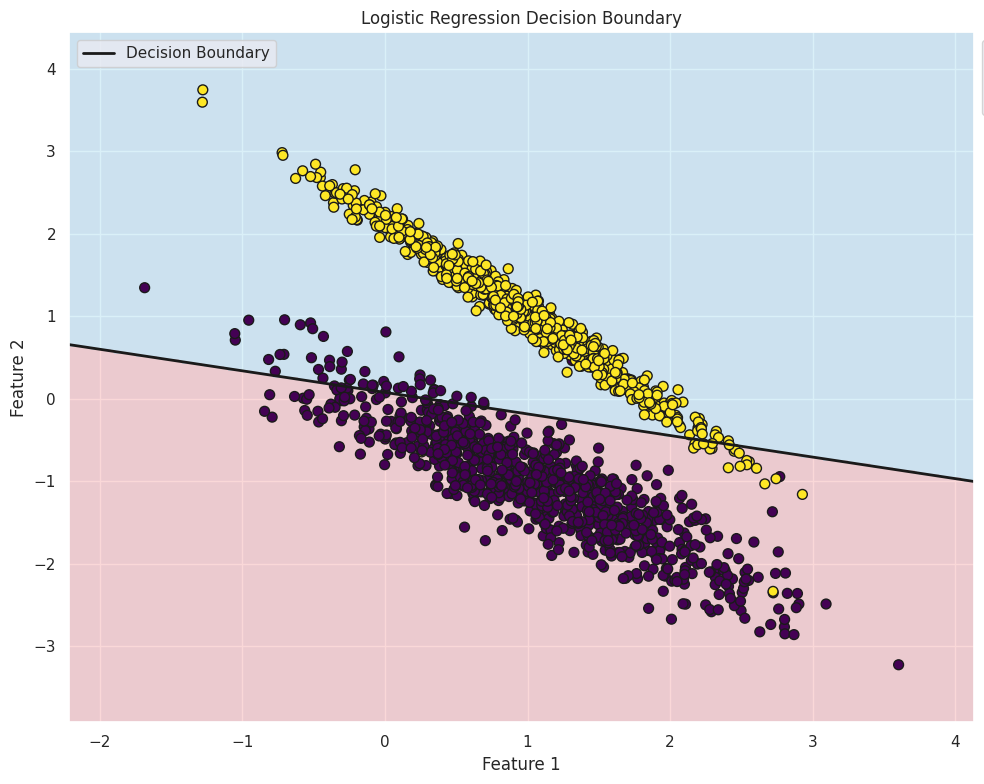

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history_, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Value Over Iterations')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

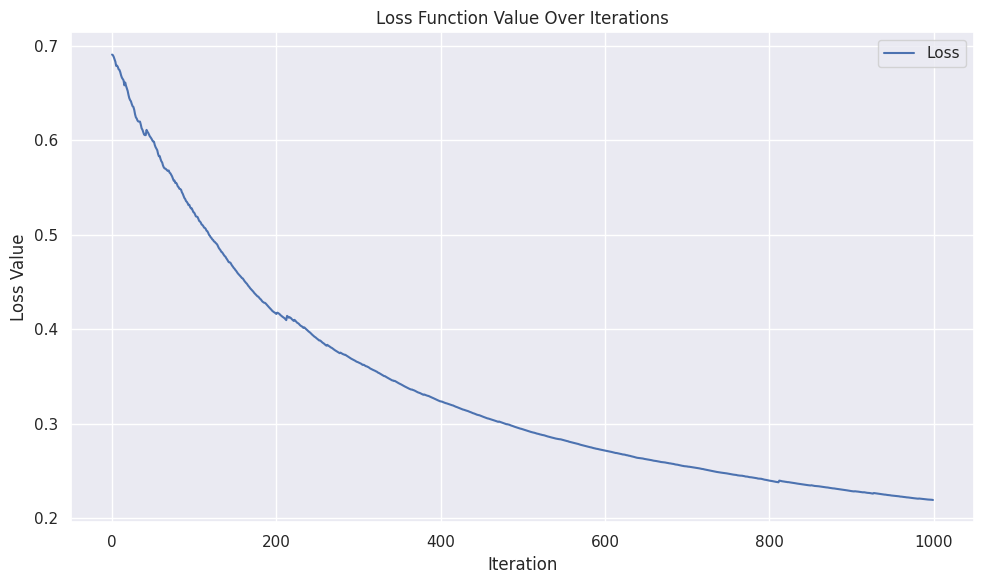

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [13]:
# Проверка уникальных меток
unique_labels = np.unique(y)
print(f"Уникальные метки в y: {unique_labels}")
print(f"Количество уникальных меток: {len(unique_labels)}")

# Проверка на {0, 1}
if len(unique_labels) != 2 or set(unique_labels) != {0, 1}:
    print(f"Ошибка: Ожидаемые метки {{0, 1}}, получены: {set(unique_labels)}")
    if set(unique_labels) == {-1, 1}:
        print("Преобразуем метки из {-1, 1} в {0, 1}")
        y = (y + 1) // 2
        unique_labels = np.unique(y)
    else:
        print("Неожиданный формат меток.")
        raise ValueError(f"Labels y must be in {{0, 1}} or {{-1, 1}}, got {set(unique_labels)}")

y_for_metrics = y
y_svm_labels = y

# Параметры для перебора
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]

# Словарь для хранения результатов
results = []

# Перебор параметров
for kernel in kernels:
    for C in C_values:
        # Создание и обучение модели
        model_svm = SVC(kernel=kernel, C=C, random_state=42, probability=True)
        model_svm.fit(X, y_svm_labels)

        # Предсказания
        y_pred = model_svm.predict(X)
        y_pred_proba = model_svm.predict_proba(X)
        y_pred_proba_positive = y_pred_proba[:, 1]

        # Вычисление метрик
        acc = accuracy_score(y_for_metrics, y_pred)
        prec = precision_score(y_for_metrics, y_pred, labels=[0, 1], average='binary', zero_division=0)
        rec = recall_score(y_for_metrics, y_pred, labels=[0, 1], average='binary', zero_division=0)
        f1 = f1_score(y_for_metrics, y_pred, labels=[0, 1], average='binary', zero_division=0)
        try:
            auc = roc_auc_score(y_for_metrics, y_pred_proba_positive)
        except ValueError as e:
            print(f"Ошибка при вычислении AUC для kernel={kernel}, C={C}: {e}")
            auc = np.nan

        # Сохранение результатов
        results.append({
            'Kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'AUC-ROC': auc,
            'F1-Score': f1,
        })

results_df = pd.DataFrame(results)
print(results_df)

Уникальные метки в y: [-1  1]
Количество уникальных меток: 2
Ошибка: Ожидаемые метки {0, 1}, получены: {np.int64(1), np.int64(-1)}
Преобразуем метки из {-1, 1} в {0, 1}
     Kernel      C  Accuracy  Precision    Recall   AUC-ROC  F1-Score
0    linear    0.1  0.995556   0.994451  0.996663  0.996284  0.995556
1    linear    1.0  0.995556   0.994451  0.996663  0.996501  0.995556
2    linear   10.0  0.995556   0.994451  0.996663  0.996531  0.995556
3    linear  100.0  0.995556   0.994451  0.996663  0.996530  0.995556
4      poly    0.1  0.996111   0.995556  0.996663  0.995833  0.996109
5      poly    1.0  0.996111   0.995556  0.996663  0.996740  0.996109
6      poly   10.0  0.996111   0.995556  0.996663  0.996883  0.996109
7      poly  100.0  0.996111   0.995556  0.996663  0.996815  0.996109
8       rbf    0.1  0.996111   0.995556  0.996663  0.997351  0.996109
9       rbf    1.0  0.996111   0.995556  0.996663  0.998004  0.996109
10      rbf   10.0  0.996111   0.995556  0.996663  0.998357  

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [14]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta # коэффициент регуляризации L2
        self.lr = lr # размер шага градиентного спуска
        self.tolerance = tolerance # минимальное допустимое изменение параметров за итерацию (для проверки сходимости)
        self.max_iter = max_iter # максимальное число итераций до сходимости
        self.random_state = random_state # начальное значение генератора случайных чисел

    def fit(self, X, y):
        # Преобразование данных
        X = np.asarray(X)
        y = np.asarray(y)

        # Преобразование меток {0, 1} в {-1, 1}
        if set(np.unique(y)) == {0, 1}:
             y = 2 * y - 1

        # Генератор случайных чисел
        self.rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape

        # Инициализация весов и смещения
        self.w_ = self.rng.normal(0, 0.01, size=n_features)
        self.w0_ = 0.0
        # Для проверки сходимости
        prev_w = self.w_.copy()
        prev_w0 = self.w0_

        for iteration in range(self.max_iter):
            # Случайный индекс для SGD
            idx = self.rng.randint(0, n_samples)
            x_i = X[idx:idx+1]
            y_i = y[idx]

            # Линейный вывод для одного примера
            linear_output_i = self.w_.T @ x_i.T + self.w0_ # (1,)
            margin_i = y_i * linear_output_i[0] # scalar

            # Обновление градиента в зависимости от margin
            if margin_i < 1:
                grad_w_no_reg = - y_i * x_i[0]
                grad_w_reg = 2 * self.beta * self.w_
                grad_w_total = grad_w_no_reg + grad_w_reg
                grad_w0_total = - y_i
            else:
                grad_w_total = np.zeros_like(self.w_)
                grad_w0_total = 0.0

            # Обновление параметров
            self.w_ = self.w_ - self.lr * grad_w_total
            self.w0_ = self.w0_ - self.lr * grad_w0_total

            # Проверка сходимости
            w_change = np.linalg.norm(self.w_ - prev_w)
            w0_change = abs(self.w0_ - prev_w0)
            total_change = w_change + abs(w0_change)
            if total_change < self.tolerance:
                print(f"HingeLossClassifier converged after {iteration + 1} iterations.")
                break

            # Обновление предыдущих значений
            prev_w = self.w_.copy()
            prev_w0 = self.w0_

        self.n_features_in_ = n_features
        return self

    def predict(self, X):
        # Преобразование данных
        X = np.asarray(X)
        # Линейный вывод
        linear_output = X @ self.w_ + self.w0_
        # Предсказание знака линейного вывода
        return np.sign(linear_output).astype(int)

# Преобразование меток для Hinge Loss
y_hinge_input = 2 * y - 1
# Создание и обучение модели
hinge_clf = HingeLossClassifier(beta=1.0, lr=1e-2, max_iter=1000, random_state=42)
hinge_clf.fit(X, y_hinge_input)
# Предсказания
y_pred_hinge_raw = hinge_clf.predict(X)
y_pred_hinge = (y_pred_hinge_raw + 1) // 2

# Вычисление метрик
acc_hinge = accuracy_score(y, y_pred_hinge) # y - истинные метки {0, 1}
prec_hinge = precision_score(y, y_pred_hinge, average='binary', zero_division=0)
rec_hinge = recall_score(y, y_pred_hinge, average='binary', zero_division=0)
f1_hinge = f1_score(y, y_pred_hinge, average='binary', zero_division=0)
y_scores_hinge = X @ hinge_clf.w_ + hinge_clf.w0_
auc_hinge = roc_auc_score(y, y_scores_hinge)

print("--- Метрики HingeLossClassifier ---")
print(f"Accuracy:  {acc_hinge:.4f}")
print(f"Precision: {prec_hinge:.4f}")
print(f"Recall:    {rec_hinge:.4f}")
print(f"AUC-ROC:   {auc_hinge:.4f}")
print(f"F1-Score:  {f1_hinge:.4f}")

HingeLossClassifier converged after 58 iterations.
--- Метрики HingeLossClassifier ---
Accuracy:  0.7967
Precision: 0.9587
Recall:    0.6196
AUC-ROC:   0.9399
F1-Score:  0.7527


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from collections import Counter

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        # Проверка параметров
        if n_neighbors <= 0:
            raise ValueError("n_neighbors must be a positive integer.")
        if metric not in ['euclidean', 'cosine']:
            raise ValueError(f"Unsupported metric '{metric}'. Supported: 'euclidean', 'manhattan', 'cosine'")
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        # Сохранение обучающих данных
        self.X_train_ = np.asarray(X)
        self.y_train_ = np.asarray(y)
        self.classes_ = np.unique(self.y_train_)
        # Проверка числа классов
        if len(self.classes_) < 2:
            raise ValueError("Training data must contain at least 2 classes.")
        self.n_features_in_ = self.X_train_.shape[1]
        return self

    def _compute_distances(self, X):
        # Вычисление расстояний в зависимости от метрики
        X = np.asarray(X)
        if self.metric == 'euclidean':
            X_train_norms_sq = np.sum(self.X_train_ ** 2, axis=1)
            X_norms_sq = np.sum(X ** 2, axis=1)[:, np.newaxis]
            cross_prod = X @ self.X_train_.T
            dist_sq = X_norms_sq + X_train_norms_sq - 2 * cross_prod
            return np.sqrt(np.maximum(dist_sq, 0))

        elif self.metric == 'cosine':
            norms_train = np.linalg.norm(self.X_train_, axis=1)
            norms_test = np.linalg.norm(X, axis=1)
            dot_products = X @ self.X_train_.T
            norms_product = norms_test[:, np.newaxis] * norms_train
            cos_sim = np.divide(dot_products, norms_product, out=np.ones_like(dot_products)*-2, where=norms_product!=0)
            cos_sim = np.clip(cos_sim, -1.0, 1.0)
            cos_dist = 1 - cos_sim
            return cos_dist

    def predict(self, X):
        # Преобразование данных
        X = np.asarray(X)
        # Вычисление расстояний
        distances = self._compute_distances(X)
        predictions = []

        for i in range(X.shape[0]):
            # Индексы k ближайших соседей
            k_nearest_indices = np.argpartition(distances[i], self.n_neighbors)[:self.n_neighbors]
            k_nearest_labels = self.y_train_[k_nearest_indices]
            # Голосование
            counts = Counter(k_nearest_labels)
            most_common_label = counts.most_common(1)[0][0]
            predictions.append(most_common_label)

        return np.array(predictions)

    def predict_proba(self, X):
        # Преобразование данных
        X = np.asarray(X)
        # Вычисление расстояний
        distances = self._compute_distances(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)

        # Инициализация вероятностей
        probas = np.zeros((n_samples, n_classes))

        for i in range(X.shape[0]):
            # Индексы k ближайших соседей
            k_nearest_indices = np.argpartition(distances[i], self.n_neighbors)[:self.n_neighbors]
            k_nearest_labels = self.y_train_[k_nearest_indices]
            # Подсчет голосов
            counts = Counter(k_nearest_labels)
            for j, class_label in enumerate(self.classes_):
                probas[i, j] = counts.get(class_label, 0) / self.n_neighbors

        return probas

# Создание и обучение модели KNN
knn_clf = KNNClassifier(n_neighbors=5, metric='euclidean')
knn_clf.fit(X, y)
# Предсказания
y_pred_knn = knn_clf.predict(X)
y_proba_knn = knn_clf.predict_proba(X)
y_scores_knn = y_proba_knn[:, 1]

# Вычисление метрик
acc_knn = accuracy_score(y, y_pred_knn)
prec_knn = precision_score(y, y_pred_knn, average='binary', zero_division=0)
rec_knn = recall_score(y, y_pred_knn, average='binary', zero_division=0)
f1_knn = f1_score(y, y_pred_knn, average='binary', zero_division=0)
auc_knn = roc_auc_score(y, y_scores_knn)

print("--- Метрики KNNClassifier (n_neighbors=5, metric='euclidean') ---")
print(f"Accuracy:  {acc_knn:.4f}")
print(f"Precision: {prec_knn:.4f}")
print(f"Recall:    {rec_knn:.4f}")
print(f"AUC-ROC:   {auc_knn:.4f}")
print(f"F1-Score:  {f1_knn:.4f}")

--- Метрики KNNClassifier (n_neighbors=5, metric='euclidean') ---
Accuracy:  0.9956
Precision: 0.9945
Recall:    0.9967
AUC-ROC:   0.9999
F1-Score:  0.9956


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
import tensorflow as tf

# Загрузка Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Объединение и разбиение в требуемой пропорции
X_all = np.concatenate([X_train_full, X_test], axis=0)
y_all = np.concatenate([y_train_full, y_test], axis=0)
X_train = X_all[:50000]
y_train = y_all[:50000]
X_test = X_all[50000:]
y_test = y_all[50000:]


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

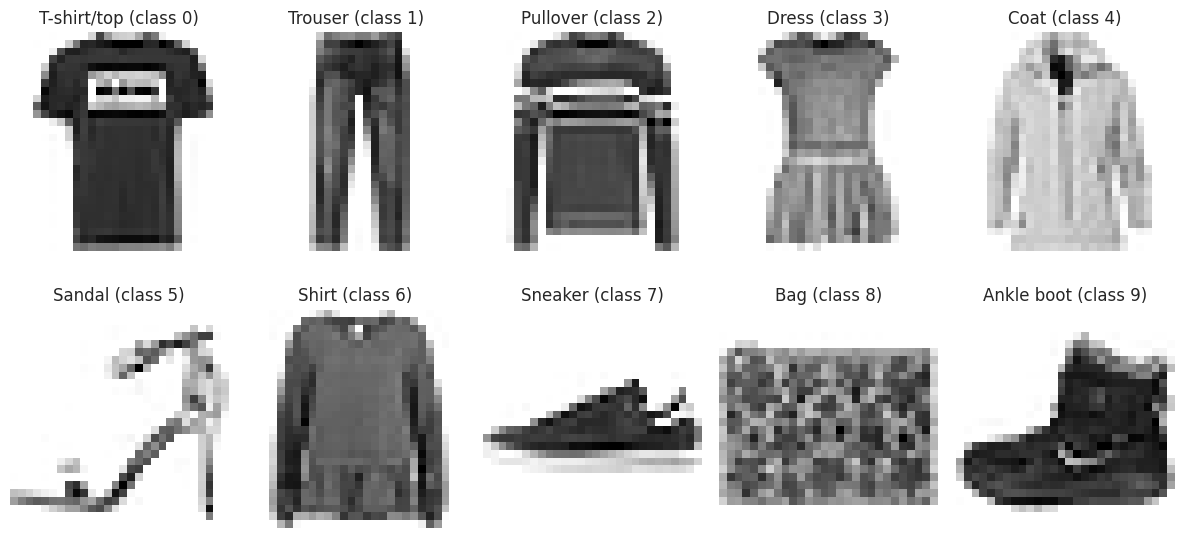

In [ ]:
# Названия классов
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Нахождение индексов первых вхождений каждого класса
num_classes = 10
indices_to_plot = []
for class_id in range(num_classes):
    idx = np.where(y_train == class_id)[0][0]
    indices_to_plot.append(idx)

# Визуализация
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i, idx in enumerate(indices_to_plot):
    axes[i].imshow(X_train[idx], cmap=plt.cm.binary)
    axes[i].set_title(f'{class_names[y_train[idx]]} (class {y_train[idx]})')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"X_train dtype: {X_train.dtype}, X_test dtype: {X_test.dtype}")

# Преобразование в плоские векторы признаков
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(f"X_train_flat shape: {X_train_flat.shape}, X_test_flat shape: {X_test_flat.shape}")

# Исходные данные
print("\n--- Статистика до нормализации (X_train_flat) ---")
print(f"Min: {X_train_flat.min():.2f}, Max: {X_train_flat.max():.2f}")
print(f"Mean: {X_train_flat.mean():.2f}, Std: {X_train_flat.std():.2f}")

# StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_flat)
X_test_std = scaler_std.transform(X_test_flat)
print("\n--- Статистика после StandardScaler (X_train_std) ---")
print(f"Min: {X_train_std.min():.2f}, Max: {X_train_std.max():.2f}")
print(f"Mean: {X_train_std.mean():.2f}, Std: {X_train_std.std():.2f}")
print("Статистика для X_test_std:")
print(f"Min: {X_test_std.min():.2f}, Max: {X_test_std.max():.2f}")
print(f"Mean: {X_test_std.mean():.2f}, Std: {X_test_std.std():.2f}")

# MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_flat)
X_test_minmax = scaler_minmax.transform(X_test_flat)
print("\n--- Статистика после MinMaxScaler (X_train_minmax) ---")
print(f"Min: {X_train_minmax.min():.2f}, Max: {X_train_minmax.max():.2f}")
print(f"Mean: {X_train_minmax.mean():.2f}, Std: {X_train_minmax.std():.2f}")
print("Статистика для X_test_minmax:")
print(f"Min: {X_test_minmax.min():.2f}, Max: {X_test_minmax.max():.2f}")
print(f"Mean: {X_test_minmax.mean():.2f}, Std: {X_test_minmax.std():.2f}")

X_train shape: (50000, 28, 28), X_test shape: (20000, 28, 28)
X_train dtype: float32, X_test dtype: float32
X_train_flat shape: (50000, 784), X_test_flat shape: (20000, 784)

--- Статистика до нормализации (X_train_flat) ---
Min: 0.00, Max: 255.00
Mean: 72.80, Std: 89.96

--- Статистика после StandardScaler (X_train_std) ---
Min: -2.40, Max: 170.19
Mean: -0.00, Std: 1.00
Статистика для X_test_std:
Min: -2.40, Max: 272.41
Mean: 0.01, Std: 1.00

--- Статистика после MinMaxScaler (X_train_minmax) ---
Min: 0.00, Max: 1.00
Mean: 0.29, Std: 0.35
Статистика для X_test_minmax:
Min: 0.00, Max: 1.83
Mean: 0.29, Std: 0.35


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Подбор гиперпараметров для KNNClassifier

""" n_neighbors:
Ключевой параметр, определяющий баланс между смещением и дисперсией.
Малый k дает низкое смещение, но высокую дисперсию (шум).
Большой k дает более гладкое решение (низкая дисперсия), но может увеличить смещение (недообучение).
Перебор позволяет найти оптимальный баланс.
"""

""" metric:
Влияет на определение "близости".
"""

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'metric': ['euclidean', 'cosine']
}

knn = KNNClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5, # 5 фолдов
    n_jobs=1,
    verbose=2
)

# Преобразование данных
y_train_knn = y_train
grid_search_knn.fit(X_train_std, y_train_knn)

print("Лучшие параметры KNN:", grid_search_knn.best_params_)
print("Лучшая кросс-валидационная точность KNN:", grid_search_knn.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....................metric=euclidean, n_neighbors=1; total time=  27.9s
[CV] END ....................metric=euclidean, n_neighbors=1; total time=  16.8s
[CV] END ....................metric=euclidean, n_neighbors=1; total time=  16.7s
[CV] END ....................metric=euclidean, n_neighbors=1; total time=  13.8s
[CV] END ....................metric=euclidean, n_neighbors=1; total time=  14.2s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=  15.0s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=  15.2s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=  15.2s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=  15.0s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=  15.0s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  15.3s
[CV] END ....................metric=euclidean, n

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Поскольку все объекты имеют одинаковые признаки, невозможно провести никакую линейную гиперплоскость (в данном случае, прямую линию), которая бы разделила классы. Все точки находятся в одном и том же месте в пространстве признаков. Любой линейный классификатор будет выдавать одинаковое предсказание для всех объектов, независимо от их истинной метки.

Наша модель "обучится", найдет какие-то веса. Линейный вывод будет одинаковым для всех объектов. Соответственно, и сигмоида будет одинаковой, равно как и предсказанная метка.

Функция потерь не будет стремиться к 0, так как модель не может идеально предсказать разные метки, имея одинаковые признаки. Она будет стремиться к минимуму, который достигается, когда модель "угадывает" наиболее вероятный класс.

SGD будет пытаться минимизировать функцию потерь. Поскольку градиенты зависят от разницы между предсказанием и истинной меткой, а признаки одинаковы, обновления весов будут зависеть от общего баланса ошибок на всем датасете. В итоге, SGD сойдется к состоянию, где модель выдает одинаковую вероятность (близкую к 0.5, если классы сбалансированы) для всех объектов, и одинаковую предсказанную метку.

In [ ]:
# Параметры задачи
N = 10000
N_pos = 5000
N_neg = 5000
# Значения признаков для всех объектов одинаковы
feature_values = [1.0, 2.0]

# Создание датасета
X = np.tile(feature_values, (N, 1))
y_raw = np.concatenate([np.ones(N_pos), -np.ones(N_neg)])
# Перемешивание
rng = np.random.RandomState(42)
shuffled_indices = rng.permutation(N)
X = X[shuffled_indices]
y = y_raw[shuffled_indices]

print(f"X.shape: {X.shape}, y.shape: {y.shape}")
print(f"Уникальные значения X: {np.unique(X, axis=0)}")
print(f"Уникальные значения y: {np.unique(y)}")
print(f"Количество +1: {np.sum(y == 1)}, количество -1: {np.sum(y == -1)}")

# Обучение модели, минимальная регуляризация
model_logit = Logit(beta=0.0, gamma=0.0, lr=0.01, max_iter=1000, tolerance=1e-8, random_state=42)
print("\n--- Обучение Logit ---")
model_logit.fit(X, y)
print(f"\nОбученные веса w: {model_logit.w_}")
print(f"Обученное смещение w0: {model_logit.w0_}")

# Предсказания
y_pred_all = model_logit.predict(X)
y_pred_proba_all = model_logit.predict_proba(X)

print(f"\nВсе ли предсказанные метки одинаковы? {len(np.unique(y_pred_all)) == 1}")
print(f"Уникальные предсказанные метки: {np.unique(y_pred_all)}")
print(f"Пример первых 10 предсказанных меток: {y_pred_all[:10]}")

print(f"\nВсе ли вероятности класса +1 одинаковы? {np.allclose(y_pred_proba_all[:, 1], y_pred_proba_all[0, 1])}")
print(f"Пример вероятностей для первых 3 объектов: \n{y_pred_proba_all[:3]}")

# Распределение предсказаний
unique_preds, counts_preds = np.unique(y_pred_all, return_counts=True)
print(f"\nРаспределение предсказаний: {dict(zip(unique_preds, counts_preds))}")

# Вероятности классов +1 и -1
prob_plus_one = y_pred_proba_all[0, 1]
prob_minus_one = y_pred_proba_all[0, 0]
print(f"\nПредсказанная вероятность класса +1: {prob_plus_one:.6f}")
print(f"Предсказанная вероятность класса -1: {prob_minus_one:.6f}")

# Обучение с регуляризацией
print("\n--- Обучение Logit с L2 регуляризацией ---")
model_logit_reg = Logit(beta=1.0, gamma=0.0, lr=0.01, max_iter=1000, tolerance=1e-8, random_state=42)
model_logit_reg.fit(X, y)

print(f"\nОбученные веса w (с регуляризацией): {model_logit_reg.w_}")
print(f"Обученное смещение w0 (с регуляризацией): {model_logit_reg.w0_}")

y_pred_all_reg = model_logit_reg.predict(X)
y_pred_proba_all_reg = model_logit_reg.predict_proba(X)

print(f"\nВсе ли предсказанные метки одинаковы (с регуляризацией)? {len(np.unique(y_pred_all_reg)) == 1}")
prob_plus_one_reg = y_pred_proba_all_reg[0, 1]
prob_minus_one_reg = y_pred_proba_all_reg[0, 0]
print(f"Предсказанная вероятность класса +1 (с регуляризацией): {prob_plus_one_reg:.6f}")
print(f"Предсказанная вероятность класса -1 (с регуляризацией): {prob_minus_one_reg:.6f}")

X.shape: (10000, 2), y.shape: (10000,)
Уникальные значения X: [[1. 2.]]
Уникальные значения y: [-1.  1.]
Количество +1: 5000, количество -1: 5000

--- Обучение Logit ---

Обученные веса w: [0.005599062201043474, -0.00011880166984963407]
Обученное смещение w0: 0.0006319206709311251

Все ли предсказанные метки одинаковы? True
Уникальные предсказанные метки: [1]
Пример первых 10 предсказанных меток: [1 1 1 1 1 1 1 1 1 1]

Все ли вероятности класса +1 одинаковы? True
Пример вероятностей для первых 3 объектов: 
[[0.49850166 0.50149834]
 [0.49850166 0.50149834]
 [0.49850166 0.50149834]]

Распределение предсказаний: {np.int64(1): np.int64(10000)}

Предсказанная вероятность класса +1: 0.501498
Предсказанная вероятность класса -1: 0.498502

--- Обучение Logit с L2 регуляризацией ---

Обученные веса w (с регуляризацией): [0.00676550750415601, 0.013531014989265996]
Обученное смещение w0 (с регуляризацией): -0.046989027389037825

Все ли предсказанные метки одинаковы (с регуляризацией)? True
Предск